# Setting

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import keras
import random
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import nltk
nltk.download('wordnet')
import os

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


# Data loading

In [3]:
train_data, validation_data, test_data = tfds.load(
    name="imdb_reviews", 
    split=('train[:80%]', 'train[20%:]', 'test'),
    as_supervised=True)

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteU21KDQ/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteU21KDQ/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteU21KDQ/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


# N-gram model

## Binary, Word_count, Tfidf

In [ ]:
path = '/content/drive/MyDrive/CS229/Final/movie_data/full_train.txt'
reviews_train = []
for line in open(path, 'r'):
    reviews_train.append(line.strip())

In [ ]:
path = '/content/drive/MyDrive/CS229/Final/movie_data/full_test.txt'
reviews_test = []
for line in open(path, 'r'):
    reviews_test.append(line.strip())

In [ ]:
train_label = [1 if i < 12500 else 0 for i in range(25000)]
test_label = [1 if i < 12500 else 0 for i in range(25000)]

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    reviews_train, train_label, train_size=0.8
)

In [ ]:
REPLACE_NO_SPACE = re.compile("[.;:!\'?,\"()\[\]]")
REPLACE_WITH_SPACE = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")
def preprocess_reviews(reviews):
  reviews = [REPLACE_NO_SPACE.sub("", line.lower()) for line in reviews]
  reviews = [REPLACE_WITH_SPACE.sub(" ", line) for line in reviews]
  return reviews

reviews_train_clean = preprocess_reviews(X_train)
reviews_val_clean = preprocess_reviews(X_val)
reviews_test_clean = preprocess_reviews(reviews_test)

In [ ]:
def get_lemmatized_text(corpus):
  lemmatizer = WordNetLemmatizer()
  return [' '.join([lemmatizer.lemmatize(word) for word in review.split()]) for review in corpus]

reviews_train_clean = get_lemmatized_text(reviews_train_clean)
reviews_val_clean = get_lemmatized_text(reviews_val_clean)
reviews_test_clean = get_lemmatized_text(reviews_test_clean)

In [ ]:
models = []
models.append(('Logistic', LogisticRegression(C=0.05)))
models.append(('RF', RandomForestClassifier()))
models.append(('Boosting', GradientBoostingClassifier(max_depth= 5)))
models.append(('SVC', LinearSVC(C=0.05)))
# models.append(('DNN', MLPClassifier(hidden_layer_sizes=(30,30,20,10,10), activation='logistic', early_stopping=True)))
stop_words = ['in', 'of', 'at', 'a', 'the']
preprocessing = []
preprocessing.append(('Binary', CountVectorizer(binary=True, stop_words=stop_words)))
preprocessing.append(('Count', CountVectorizer(binary=False, ngram_range=(1,3), stop_words=stop_words)))
preprocessing.append(('Tf-idf', TfidfVectorizer(ngram_range=(1, 3), stop_words=stop_words)))
# evaluate each model in turn
val_accuracy = []
test_accuracy = []
names = []
for preprocess_name, preprocess_method in preprocessing:
  preprocess_method = preprocess_method.fit(reviews_train_clean)
  X_train = preprocess_method.transform(reviews_train_clean)
  X_val = preprocess_method.transform(reviews_val_clean)
  X_test = preprocess_method.transform(reviews_test_clean)
  for name, model in models:  
    model.fit(X_train, y_train)
    val_label = model.predict(X_val)
    val_accuracy.append(accuracy_score(val_label, y_val))
    y_pred = model.predict(X_test)
    test_accuracy.append(accuracy_score(test_label, y_pred))
    names.append(name + '-' + preprocess_name)
    print('%s val_accuracy: %f, test_accuracy: %f' % (name + '-' + preprocess_name, accuracy_score(val_label, y_val), accuracy_score(test_label, y_pred)))

Logistic-Binary val_accuracy: 0.875750, test_accuracy: 0.874600
RF-Binary val_accuracy: 0.839250, test_accuracy: 0.837960
Boosting-Binary val_accuracy: 0.824250, test_accuracy: 0.823040
SVC-Binary val_accuracy: 0.872250, test_accuracy: 0.861680


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Logistic-Count val_accuracy: 0.890000, test_accuracy: 0.886520
RF-Count val_accuracy: 0.843500, test_accuracy: 0.846240
Boosting-Count val_accuracy: 0.829000, test_accuracy: 0.829880
SVC-Count val_accuracy: 0.890250, test_accuracy: 0.888040
Logistic-Tf-idf val_accuracy: 0.828500, test_accuracy: 0.815320
RF-Tf-idf val_accuracy: 0.846250, test_accuracy: 0.841200
Boosting-Tf-idf val_accuracy: 0.818250, test_accuracy: 0.822680
SVC-Tf-idf val_accuracy: 0.861500, test_accuracy: 0.853600


### Performance

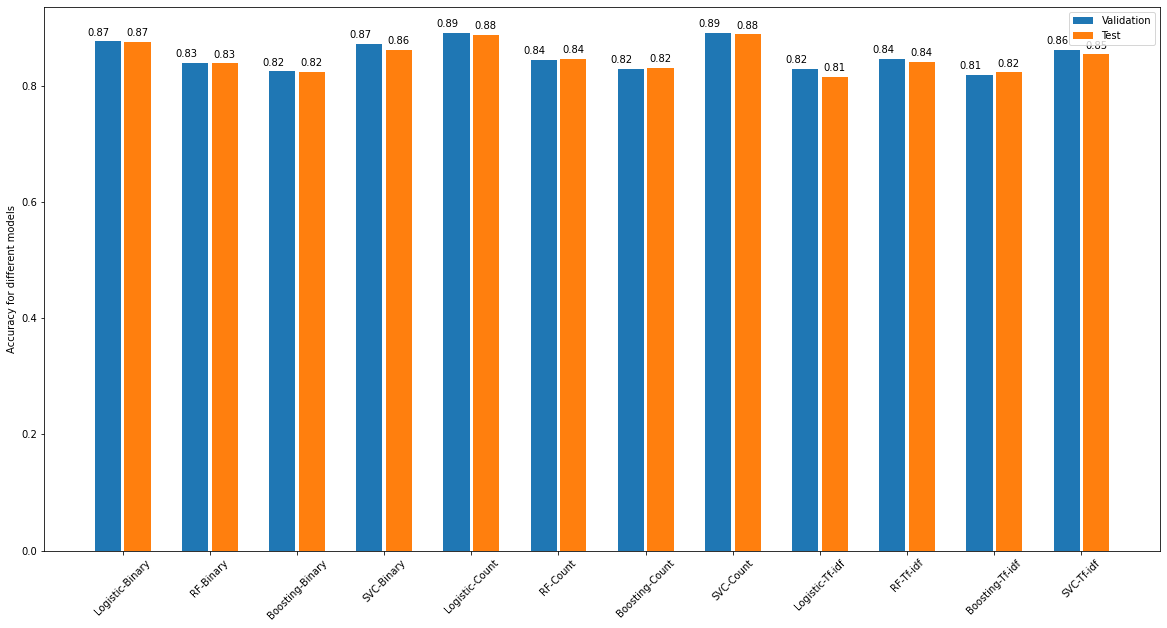

In [ ]:
x = np.arange(len(names))

width = 0.3
plt.figure(figsize = (20, 10))
plt.bar(x - 0.17, val_accuracy, width, label='Validation')
plt.bar(x + 0.17, test_accuracy, width, label='Test')
plt.xticks(ticks=x, labels=names,
           rotation=45)
for index, value in enumerate(val_accuracy):
    plt.text(index - 0.4, value+0.01, str(value)[0:4])
for index, value in enumerate(test_accuracy):
    plt.text(index + 0.04, value + 0.01, str(value)[0:4])
plt.ylabel(f'Accuracy for different models')
_ = plt.legend()

## Word Embedding

Use three embedding methods, NNLM 50, NNLM 128, NNLM 128 with normalization and universal encoder

In [ ]:
class dense_embedding(tf.keras.Model):
  
  def __init__(self, input):
    super(dense_embedding, self).__init__()
    self.hub_layer = hub.KerasLayer(input, input_shape=[], 
                           dtype=tf.string, trainable=True)
    self.dense1 = tf.keras.layers.Dense(64, activation='relu')
    self.dense2 = tf.keras.layers.Dense(32, activation='relu')
    self.res = tf.keras.layers.Dense(1, activation='sigmoid')
  
  def call(self, x):
    x = self.hub_layer(x)
    x = self.dense1(x)
    x = self.dense2(x)
    return self.res(x)

embedding_50 = "https://tfhub.dev/google/nnlm-en-dim50/2"
model = dense_embedding(embedding_50)

In [2]:
MAX_EPOCHS = 30

def compile_and_fit(model, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')
  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=500,
    decay_rate=0.9)
  model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

  history = model.fit(train_data.batch(512), epochs=MAX_EPOCHS,
                      validation_data=validation_data.batch(512))
                      # ,callbacks=[early_stopping])
  return history

In [ ]:
embedding_50 = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding_50, input_shape=[], 
                           dtype=tf.string, trainable=True)


model50 = tf.keras.Sequential()
model50.add(hub_layer)
model50.add(tf.keras.layers.Dense(64, activation='relu'))
model50.add(tf.keras.layers.Dense(32, activation='relu'))
model50.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model50.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 50)                48190600  
_________________________________________________________________
dense (Dense)                (None, 64)                3264      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 48,195,977
Trainable params: 48,195,977
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = compile_and_fit(model50)

performance = {}
val_performance = {}
val_performance['nlnm 50'] = model50.evaluate(validation_data.batch(512))
performance['nlnm 50'] = model50.evaluate(test_data.batch(512))

Epoch 1/30
40/40 [==============================] - 8s 108ms/step - loss: 0.6712 - accuracy: 0.5928 - val_loss: 0.5060 - val_accuracy: 0.7915
Epoch 2/30
40/40 [==============================] - 4s 100ms/step - loss: 0.4363 - accuracy: 0.8239 - val_loss: 0.2800 - val_accuracy: 0.8900
Epoch 3/30
40/40 [==============================] - 4s 97ms/step - loss: 0.2394 - accuracy: 0.9077 - val_loss: 0.1989 - val_accuracy: 0.9255
Epoch 4/30
40/40 [==============================] - 4s 98ms/step - loss: 0.1496 - accuracy: 0.9488 - val_loss: 0.1550 - val_accuracy: 0.9468
Epoch 5/30
40/40 [==============================] - 4s 100ms/step - loss: 0.0918 - accuracy: 0.9739 - val_loss: 0.1257 - val_accuracy: 0.9604
Epoch 6/30
40/40 [==============================] - 4s 96ms/step - loss: 0.0488 - accuracy: 0.9901 - val_loss: 0.1176 - val_accuracy: 0.9643
Epoch 7/30
40/40 [==============================] - 4s 97ms/step - loss: 0.0278 - accuracy: 0.9963 - val_loss: 0.1188 - val_accuracy: 0.9660
Epoch 8/30

In [ ]:
embedding_50 = "https://tfhub.dev/google/nnlm-en-dim128/2"
hub_layer = hub.KerasLayer(embedding_50, input_shape=[], 
                           dtype=tf.string, trainable=True)


model128 = tf.keras.Sequential()
model128.add(hub_layer)
model128.add(tf.keras.layers.Dense(64, activation='relu'))
model128.add(tf.keras.layers.Dense(32, activation='relu'))
model128.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model128.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 128)               124642688 
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 124,653,057
Trainable params: 124,653,057
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = compile_and_fit(model128)

val_performance['nlnm 128'] = model128.evaluate(validation_data.batch(512))
performance['nlnm 128'] = model128.evaluate(test_data.batch(512))

Epoch 1/30
40/40 [==============================] - 6s 138ms/step - loss: 0.6352 - accuracy: 0.6426 - val_loss: 0.3554 - val_accuracy: 0.8659
Epoch 2/30
40/40 [==============================] - 6s 135ms/step - loss: 0.2992 - accuracy: 0.8837 - val_loss: 0.1972 - val_accuracy: 0.9299
Epoch 3/30
40/40 [==============================] - 6s 137ms/step - loss: 0.1482 - accuracy: 0.9525 - val_loss: 0.1307 - val_accuracy: 0.9568
Epoch 4/30
40/40 [==============================] - 6s 135ms/step - loss: 0.0683 - accuracy: 0.9840 - val_loss: 0.1147 - val_accuracy: 0.9646
Epoch 5/30
40/40 [==============================] - 6s 135ms/step - loss: 0.0287 - accuracy: 0.9953 - val_loss: 0.1116 - val_accuracy: 0.9671
Epoch 6/30
40/40 [==============================] - 6s 135ms/step - loss: 0.0123 - accuracy: 0.9991 - val_loss: 0.1198 - val_accuracy: 0.9670
Epoch 7/30
40/40 [==============================] - 6s 135ms/step - loss: 0.0057 - accuracy: 0.9995 - val_loss: 0.1288 - val_accuracy: 0.9668
Epoch 

In [ ]:
embedding_50 = "https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2"
hub_layer = hub.KerasLayer(embedding_50, input_shape=[], 
                           dtype=tf.string, trainable=True)


model128_norm = tf.keras.Sequential()
model128_norm.add(hub_layer)
model128_norm.add(tf.keras.layers.Dense(64, activation='relu'))
model128_norm.add(tf.keras.layers.Dense(32, activation='relu'))
model128_norm.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model128_norm.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 128)               124642688 
_________________________________________________________________
dense_6 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_7 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 33        
Total params: 124,653,057
Trainable params: 124,653,057
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = compile_and_fit(model128_norm)

val_performance['nlnm 128_norm'] = model128_norm.evaluate(validation_data.batch(512))
performance['nlnm 128_norm'] = model128_norm.evaluate(test_data.batch(512))

Epoch 1/30
40/40 [==============================] - 7s 151ms/step - loss: 0.6029 - accuracy: 0.7063 - val_loss: 0.2968 - val_accuracy: 0.8876
Epoch 2/30
40/40 [==============================] - 6s 149ms/step - loss: 0.2517 - accuracy: 0.9067 - val_loss: 0.1618 - val_accuracy: 0.9433
Epoch 3/30
40/40 [==============================] - 6s 149ms/step - loss: 0.1244 - accuracy: 0.9593 - val_loss: 0.1131 - val_accuracy: 0.9625
Epoch 4/30
40/40 [==============================] - 6s 148ms/step - loss: 0.0614 - accuracy: 0.9853 - val_loss: 0.0929 - val_accuracy: 0.9696
Epoch 5/30
40/40 [==============================] - 6s 148ms/step - loss: 0.0245 - accuracy: 0.9967 - val_loss: 0.0912 - val_accuracy: 0.9715
Epoch 6/30
40/40 [==============================] - 6s 150ms/step - loss: 0.0114 - accuracy: 0.9988 - val_loss: 0.0938 - val_accuracy: 0.9725
Epoch 7/30
40/40 [==============================] - 6s 151ms/step - loss: 0.0054 - accuracy: 0.9997 - val_loss: 0.1006 - val_accuracy: 0.9723
Epoch 

In [ ]:
embedding_50 = "https://tfhub.dev/google/universal-sentence-encoder/4"
hub_layer = hub.KerasLayer(embedding_50, input_shape=[], 
                           dtype=tf.string, trainable=True)


model512 = tf.keras.Sequential()
model512.add(hub_layer)
model512.add(tf.keras.layers.Dense(64, activation='relu'))
model512.add(tf.keras.layers.Dense(32, activation='relu'))
model512.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model512.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_3 (KerasLayer)   (None, 512)               256797824 
_________________________________________________________________
dense_9 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_10 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 33        
Total params: 256,832,769
Trainable params: 256,832,769
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = compile_and_fit(model512)

val_performance['dan 512'] = model512.evaluate(validation_data.batch(512))
performance['dan 512'] = model512.evaluate(test_data.batch(512))

Epoch 1/30
40/40 [==============================] - 54s 1s/step - loss: 0.5960 - accuracy: 0.7364 - val_loss: 0.2832 - val_accuracy: 0.8850
Epoch 2/30
40/40 [==============================] - 50s 1s/step - loss: 0.2166 - accuracy: 0.9176 - val_loss: 0.1294 - val_accuracy: 0.9570
Epoch 3/30
40/40 [==============================] - 50s 1s/step - loss: 0.0562 - accuracy: 0.9887 - val_loss: 0.1028 - val_accuracy: 0.9689
Epoch 4/30
40/40 [==============================] - 49s 1s/step - loss: 0.0173 - accuracy: 0.9965 - val_loss: 0.0909 - val_accuracy: 0.9729
Epoch 5/30
40/40 [==============================] - 49s 1s/step - loss: 0.0031 - accuracy: 0.9997 - val_loss: 0.0933 - val_accuracy: 0.9736
Epoch 6/30
40/40 [==============================] - 49s 1s/step - loss: 0.0014 - accuracy: 0.9999 - val_loss: 0.0968 - val_accuracy: 0.9736
Epoch 7/30
40/40 [==============================] - 49s 1s/step - loss: 7.7723e-04 - accuracy: 1.0000 - val_loss: 0.1002 - val_accuracy: 0.9735
Epoch 8/30
40/40

### Comparison

Make the embedding layers trainable improve the performance.

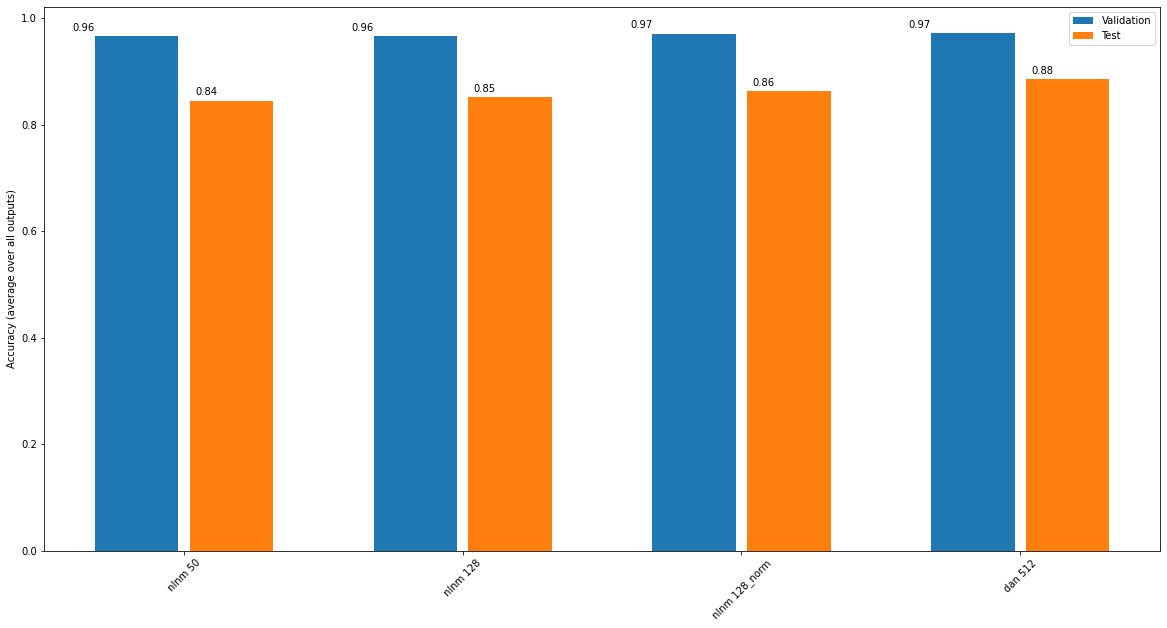

In [ ]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'accuracy'
metric_index = model512.metrics_names.index('accuracy')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.figure(figsize = (20, 10))
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
for index, value in enumerate(val_mae):
    plt.text(index - 0.4, value+0.01, str(value)[0:4])
for index, value in enumerate(test_mae):
    plt.text(index + 0.04, value + 0.01, str(value)[0:4])
plt.ylabel('Accuracy (average over all outputs)')

_ = plt.legend()

# Sequence model

## RNN

### Text Encoder

In [4]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_data.map(lambda text, label: text))

### Model

In [5]:
model_lstm = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [6]:
history = compile_and_fit(model_lstm)

val_performance={}
performance={}
val_performance['LSTM'] = model_lstm.evaluate(validation_data.batch(512))
performance['LSTM'] = model_lstm.evaluate(test_data.batch(512))

Epoch 1/30
40/40 [==============================] - 55s 417ms/step - loss: 0.6829 - accuracy: 0.5083 - val_loss: 0.4836 - val_accuracy: 0.7678
Epoch 2/30
40/40 [==============================] - 14s 347ms/step - loss: 0.4436 - accuracy: 0.7896 - val_loss: 0.3615 - val_accuracy: 0.8524
Epoch 3/30
40/40 [==============================] - 14s 351ms/step - loss: 0.3388 - accuracy: 0.8546 - val_loss: 0.3871 - val_accuracy: 0.8575
Epoch 4/30
40/40 [==============================] - 14s 350ms/step - loss: 0.3309 - accuracy: 0.8637 - val_loss: 0.3372 - val_accuracy: 0.8688
Epoch 5/30
40/40 [==============================] - 14s 347ms/step - loss: 0.3101 - accuracy: 0.8702 - val_loss: 0.3017 - val_accuracy: 0.8781
Epoch 6/30
40/40 [==============================] - 14s 352ms/step - loss: 0.2966 - accuracy: 0.8765 - val_loss: 0.3016 - val_accuracy: 0.8737
Epoch 7/30
40/40 [==============================] - 14s 350ms/step - loss: 0.2979 - accuracy: 0.8719 - val_loss: 0.3069 - val_accuracy: 0.8777

In [7]:
model_doubleLSTM = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 100, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [8]:
history = compile_and_fit(model_doubleLSTM)

val_performance['Double LSTM'] = model_doubleLSTM.evaluate(validation_data.batch(512))
performance['Double LSTM'] = model_doubleLSTM.evaluate(test_data.batch(512))

Epoch 1/30
40/40 [==============================] - 43s 710ms/step - loss: 0.6731 - accuracy: 0.5225 - val_loss: 0.6169 - val_accuracy: 0.7405
Epoch 2/30
40/40 [==============================] - 24s 616ms/step - loss: 0.4427 - accuracy: 0.8006 - val_loss: 0.3550 - val_accuracy: 0.8597
Epoch 3/30
40/40 [==============================] - 24s 613ms/step - loss: 0.3421 - accuracy: 0.8556 - val_loss: 0.3510 - val_accuracy: 0.8683
Epoch 4/30
40/40 [==============================] - 24s 612ms/step - loss: 0.3184 - accuracy: 0.8679 - val_loss: 0.3371 - val_accuracy: 0.8723
Epoch 5/30
40/40 [==============================] - 24s 615ms/step - loss: 0.3196 - accuracy: 0.8706 - val_loss: 0.3565 - val_accuracy: 0.8634
Epoch 6/30
40/40 [==============================] - 24s 613ms/step - loss: 0.3183 - accuracy: 0.8684 - val_loss: 0.3061 - val_accuracy: 0.8762
Epoch 7/30
40/40 [==============================] - 24s 612ms/step - loss: 0.3032 - accuracy: 0.8722 - val_loss: 0.2942 - val_accuracy: 0.8726

### Model with pretrained embedding layer

In [9]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2021-04-14 19:38:23--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-04-14 19:38:23--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-04-14 19:38:23--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [10]:
# convert encoder to dict (word as key index as value)
word_index = dict(zip(encoder.get_vocabulary(), range(1000)))

In [11]:
# convert txt to dictionary (word as key, coefs as value)
path_to_glove_file = '/content/glove.6B.100d.txt'

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [12]:
# integrate the above two dict to create a embedding matrix for the encoder of the model
num_tokens = 1000
embedding_dim = 100
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 993 words (7 misses)


In [13]:
model_lstm_pretrained = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=100,
        embeddings_initializer = keras.initializers.Constant(embedding_matrix),
        trainable = True,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [14]:
history = compile_and_fit(model_lstm_pretrained)

val_performance['LSTM_pretrain'] = model_lstm_pretrained.evaluate(validation_data.batch(512))
performance['LSTM_pretrain'] = model_lstm_pretrained.evaluate(test_data.batch(512))

Epoch 1/30
40/40 [==============================] - 26s 470ms/step - loss: 0.6770 - accuracy: 0.5223 - val_loss: 0.5757 - val_accuracy: 0.6527
Epoch 2/30
40/40 [==============================] - 16s 416ms/step - loss: 0.5524 - accuracy: 0.6997 - val_loss: 0.4700 - val_accuracy: 0.7440
Epoch 3/30
40/40 [==============================] - 17s 418ms/step - loss: 0.4571 - accuracy: 0.7783 - val_loss: 0.3908 - val_accuracy: 0.8291
Epoch 4/30
40/40 [==============================] - 17s 417ms/step - loss: 0.3890 - accuracy: 0.8199 - val_loss: 0.3670 - val_accuracy: 0.8483
Epoch 5/30
40/40 [==============================] - 17s 417ms/step - loss: 0.3582 - accuracy: 0.8411 - val_loss: 0.3529 - val_accuracy: 0.8564
Epoch 6/30
40/40 [==============================] - 16s 416ms/step - loss: 0.3591 - accuracy: 0.8406 - val_loss: 0.4088 - val_accuracy: 0.8375
Epoch 7/30
40/40 [==============================] - 17s 418ms/step - loss: 0.3473 - accuracy: 0.8446 - val_loss: 0.3095 - val_accuracy: 0.8587

In [15]:
model_doubleLSTM_pretrain = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=100,
        embeddings_initializer = keras.initializers.Constant(embedding_matrix),
        trainable = True,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [16]:
history = compile_and_fit(model_doubleLSTM_pretrain)

val_performance['Double LSTM_pretrain'] = model_doubleLSTM_pretrain.evaluate(validation_data.batch(512))
performance['Double LSTM_pretrain'] = model_doubleLSTM_pretrain.evaluate(test_data.batch(512))

Epoch 1/30
40/40 [==============================] - 43s 716ms/step - loss: 0.6871 - accuracy: 0.5071 - val_loss: 0.6317 - val_accuracy: 0.5764
Epoch 2/30
40/40 [==============================] - 24s 609ms/step - loss: 0.6103 - accuracy: 0.6457 - val_loss: 0.4821 - val_accuracy: 0.7800
Epoch 3/30
40/40 [==============================] - 24s 609ms/step - loss: 0.4686 - accuracy: 0.7764 - val_loss: 0.4321 - val_accuracy: 0.7595
Epoch 4/30
40/40 [==============================] - 24s 613ms/step - loss: 0.4135 - accuracy: 0.8081 - val_loss: 0.3514 - val_accuracy: 0.8437
Epoch 5/30
40/40 [==============================] - 24s 612ms/step - loss: 0.3705 - accuracy: 0.8353 - val_loss: 0.3596 - val_accuracy: 0.8550
Epoch 6/30
40/40 [==============================] - 24s 610ms/step - loss: 0.3671 - accuracy: 0.8359 - val_loss: 0.3259 - val_accuracy: 0.8454
Epoch 7/30
40/40 [==============================] - 24s 610ms/step - loss: 0.3351 - accuracy: 0.8508 - val_loss: 0.3142 - val_accuracy: 0.8694

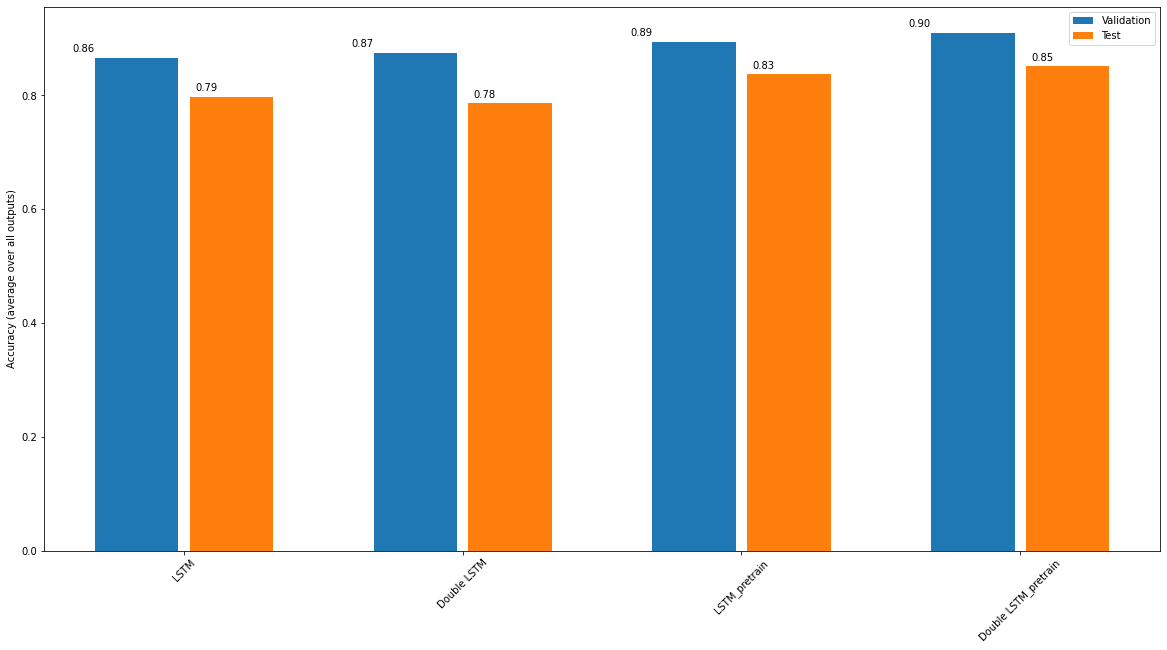

In [17]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'accuracy'
metric_index = model_doubleLSTM.metrics_names.index('accuracy')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.figure(figsize = (20, 10))
plt.ylabel('Accuracy (average over all outputs)')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
for index, value in enumerate(val_mae):
    plt.text(index - 0.4, value+0.01, str(value)[0:4])
for index, value in enumerate(test_mae):
    plt.text(index + 0.04, value + 0.01, str(value)[0:4])


_ = plt.legend()

## BERT 

In [ ]:
!pip install tensorflow_text
import tensorflow_text as text  # Registers the ops.

In [ ]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3", name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer('https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1', trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [ ]:
model_Bert = build_classifier_model()
history = compile_and_fit(model_Bert)

val_performance['BERT'] = model_Bert.evaluate(validation_data.batch(512))
performance['BERT'] = model_Bert.evaluate(test_data.batch(512))

In [ ]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'accuracy'
metric_index = model512.metrics_names.index('accuracy')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('Accuracy (average over all outputs)')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
for index, value in enumerate(val_mae):
    plt.text(index - 0.4, value+0.01, str(value)[0:4])
for index, value in enumerate(test_mae):
    plt.text(index + 0.04, value + 0.01, str(value)[0:4])
plt.figure(figsize = (20, 10))
_ = plt.legend()

# Reference



*   https://towardsdatascience.com/sentiment-analysis-with-python-part-1-5ce197074184
*   https://towardsdatascience.com/sentiment-analysis-with-python-part-2-4f71e7bde59a
*   https://www.tensorflow.org/tutorials/text/word_embeddings
*   https://www.tensorflow.org/tutorials/text/text_classification_rnn
*   https://www.tensorflow.org/tutorials/text/classify_text_with_bert
